# Plot Figure 5

This code plots the precipitation sensitivity to $\mathrm{SUBSAT_L}$ and $\mathrm{CAPE_L}$ for HR-ERA5/IMERG, LR-ERA5/IMERG, and LR-ERA5/GPCP (Figure 5).

## Import Necessary Packages

In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from calendar import month_name
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle,Patch
pplt.rc['tick.minor']=False
warnings.filterwarnings('ignore')

## User-Defined Configurations

Specify the directory where the binned statistics datasets are, and set the directory where the figure will be saved. Specify "monthly pairs" for analysis (i.e., `MONTHPAIRS = [(6,7),(7,8)]` for June-to-July and July-to-August changes). Set the minimum sample threshold for bin inclusion for statistical calculations, and assign a color to each dataset for plotting.

In [9]:
FILEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
MONTHPAIRS   = [(6,7),(7,8)]
SAMPLETHRESH = 50
COLORS       = ['#D42028','#F2C85E','#5BA7DA']

## Load Binned Statistics Datasets

Load in each binned statistics dataset from `FILEDIR`.

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
hrimergstats = load('HR_ERA5_IMERG_binned_stats.nc')
lrimergstats = load('LR_ERA5_IMERG_binned_stats.nc')
lrgpcpstats  = load('LR_ERA5_GPCP_binned_stats.nc')

## Functions for Analysis and Plotting

Here, we use the `get_bin_mean_pr()` function to calculate the mean precipitation in each joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ bin (where the number of samples exceeds `SAMPLETHRESH`), as well as the `get_pdf()` and `get_mode()` functions to calculate the precipitating joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDF and its mode.

In [5]:
def get_bin_mean_pr(monthstats,bintype,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        blbins = monthstats.bl.values
        Q0 = monthstats.Q0.values
        Q1 = monthstats.Q1.values
        Q0[Q0==0.0] = np.nan
        binmeanpr = Q1/Q0
        binmeanpr[Q0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = monthstats.subsat.values
        capebins   = monthstats.cape.values
        P0 = monthstats.P0.values
        P1 = monthstats.P1.values
        P0[P0==0.0] = np.nan
        binmeanpr = P1/P0
        binmeanpr[P0<samplethresh] = np.nan
        return xr.DataArray(binmeanpr,coords={'subsat':subsatbins,'cape':capebins})

def get_pdf(monthstats,bintype,precipitating=False):
    if bintype=='1D':
        blbins = monthstats.bl.values
        Q0 = monthstats.Q0.values
        QE = monthstats.QE.values
        Q  = QE if precipitating else Q0
        norm = np.nansum(Q0)*np.diff(blbins)[0]
        pdf  = Q/norm
        return xr.DataArray(pdf,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = monthstats.subsat.values
        capebins   = monthstats.cape.values
        P0 = monthstats.P0.values
        PE = monthstats.PE.values
        P  = PE if precipitating else P0
        norm = np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0]
        pdf  = P/norm
        return xr.DataArray(pdf,coords={'subsat':subsatbins,'cape':capebins})

def get_mode(pdf,bintype,idxs=False):
    if bintype=='1D':
        blbins    = pdf.bl.values
        maxblidx  = np.nanargmax(pdf.values)
        blmode    = blbins[maxblidx]
        return blmode
    if bintype=='2D':
        subsatbins = pdf.subsat.values
        capebins   = pdf.cape.values
        maxsubsatidx,maxcapeidx = np.unravel_index(np.nanargmax(pdf.values),pdf.values.shape)
        if idxs:
            return maxsubsatidx,maxcapeidx
        subsatmode,capemode = subsatbins[maxsubsatidx],capebins[maxcapeidx]
        return subsatmode,capemode

The `get_sensitivity_metrics()` function divides the 2-D precipitation surface into three precipitation "regimes" based on the location of the precipitating joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDF mode. In this case, we return the individual precipitation sensitvities to $\mathrm{SUBSAT_L}$ and $\mathrm{CAPE_L}$.

In [6]:
def get_sensitivity_metrics(binmeanpr,jointpdf,prsurfaces=False,ratios=False,polar=False):
    subsatmode,capemode = get_mode(jointpdf,'2D')
    validmode = False
    for i in range(binmeanpr.subsat.size):
        if not np.isnan(binmeanpr.sel(subsat=subsatmode,cape=capemode,method='nearest')):
            validmode = True
            break
        subsatmode += binmeanpr.subsat[1]-binmeanpr.subsat[0]
    if not validmode:
        raise ValueError('Could not locate valid point for precipitation sensitivity computation.')
    binmeanpra = ~np.isnan(binmeanpr)&(binmeanpr.subsat<=subsatmode)&(binmeanpr.cape>=capemode)
    binmeanprb = ~np.isnan(binmeanpr)&(binmeanpr.subsat<=subsatmode)&(binmeanpr.cape<=capemode)
    binmeanprc = ~np.isnan(binmeanpr)&(binmeanpr.subsat>=subsatmode)&(binmeanpr.cape>=capemode)
    nomask     = ~np.isnan(binmeanpr)&~(binmeanpra|binmeanprb|binmeanprc)
    if prsurfaces==True:
        return binmeanpra,binmeanprb,binmeanprc,nomask
    subsata = binmeanpr.subsat.where(binmeanpra).mean().values
    subsatc = binmeanpr.subsat.where(binmeanprc).mean().values
    capea = binmeanpr.cape.where(binmeanpra).mean().values
    capeb = binmeanpr.cape.where(binmeanprb).mean().values
    pra = binmeanpr.where(binmeanpra).mean().values
    prb = binmeanpr.where(binmeanprb).mean().values
    prc = binmeanpr.where(binmeanprc).mean().values
    capesensitivity   = abs(pra-prb)/abs(capea-capeb)
    subsatsensitivity = abs(pra-prc)/abs(subsata-subsatc)
    if ratios==True:
        return capesensitivity,subsatsensitivity
    gamma    = capesensitivity/subsatsensitivity
    gammamag = np.sqrt(capesensitivity**2+subsatsensitivity**2)
    theta    = np.arctan(gamma)
    if polar:
        return gammamag,theta

The `create_plot()` function processes the loaded data, performs the required analyses, and generates a formatted figure with results plotted for all three datasets.

In [ ]:
def create_plot(statsdict,monthpairs=MONTHPAIRS,samplethresh=SAMPLETHRESH,colors=COLORS,filename=None):
    statslist = [item[0] for item in statsdict]
    namelist  = [item[1] for item in statsdict]
    regions   = list(statslist[0].region.values)
    fig,axs   = pplt.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]],tight=False,abc=True,grid=False,wspace='2em',hspace='4.5em',outerpad=4,refwidth=2)
    for i,region in enumerate(regions):
        monthpair  = monthpairs[0] if i<3 else monthpairs[1]
        monthnames = [month_name[month] for month in monthpair]
        xpos    = [0,1,2]
        xlabels = [f'{monthnames[0]}',f'{monthnames[1]}',f'{monthnames[1]} $-$ {monthnames[0]}']
        bxs = axs[i].twinx()
        for j,(stats,name,color) in enumerate(zip(statslist,namelist,colors)):
            subsatvalues = []
            capevalues   = []
            subsatxpos   = []
            capexpos     = []
            for k,month in enumerate(monthpair):
                monthstats = stats.sel(region=region,month=month)
                binmeanpr  = get_bin_mean_pr(monthstats,'2D',samplethresh)
                jointpdf   = get_pdf(monthstats,'2D',precipitating=True)
                capesensitivity,subsatsensitivity = get_sensitivity_metrics(binmeanpr,jointpdf,ratios=True)
                axs[i].scatter(xpos[k]-0.15,subsatsensitivity,color=color,marker='o',markersize=40,zorder=3)
                axs[i].scatter(xpos[k]+0.15,capesensitivity,color=color,marker='D',markersize=40,zorder=3)
                subsatvalues.append(subsatsensitivity)
                capevalues.append(capesensitivity)
                subsatxpos.append(xpos[k]-0.15)
                capexpos.append(xpos[k]+0.15)
            subsatdiff = subsatvalues[1]-subsatvalues[0]
            capediff   = capevalues[1]-capevalues[0]
            bxs.scatter(xpos[2]-0.15,subsatdiff,color=color,marker='o',markersize=40,zorder=3)
            bxs.scatter(xpos[2]+0.15,capediff,color=color,marker='D',markersize=40,zorder=3)
            axs[i].plot(subsatxpos[:2],subsatvalues[:2],color=color,zorder=2)
            axs[i].plot(capexpos[:2],capevalues[:2],color=color,zorder=2)
        axs[i].axvline(x=1.5,color='k',linestyle='-',linewidth=1,zorder=1)
        axs[i].format(title=region,titleloc='l',xlim=(-0.5,2.5),xticks=xpos,xticklabels=xlabels,
                      ylabel='Sensitivity (mm/day/K)' if i in [0,3] else None,
                      ylim=(0,15),yticks=3,yticklabels='auto' if i in [0,3] else None)
        bxs.format(ylabel='$\Delta$Sensitivity (mm/day/K)' if i in [2,4] else None,ylim=(-6,6),yticks=3)
        bxs.yaxis.set_tick_params(labelright=i in [2, 4])
        xlim = axs[i].get_xlim()
        xmin = (1.5-xlim[0])/(xlim[1]-xlim[0])
        bxs.axhline(y=0,xmin=xmin,xmax=1,color='k',linestyle='--',zorder=1)
    datahandles = [Patch(color=color,label=name) for color,name in zip(colors,namelist)]
    termhandles = [Line2D([0],[0],color='k',marker='o',linestyle='',label='$\mathit{\partial}P/\mathit{\partial}SUBSAT_L$'),
                   Line2D([0],[0],color='k',marker='D',linestyle='',label='$\mathit{\partial}P/\mathit{\partial}CAPE_L$')]
    fig.legend(handles=datahandles+termhandles,loc='b',ncols=5)
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)
    pplt.show()

## Plot and Save Figure

Execute plotting, and save the figure to `SAVEDIR`.

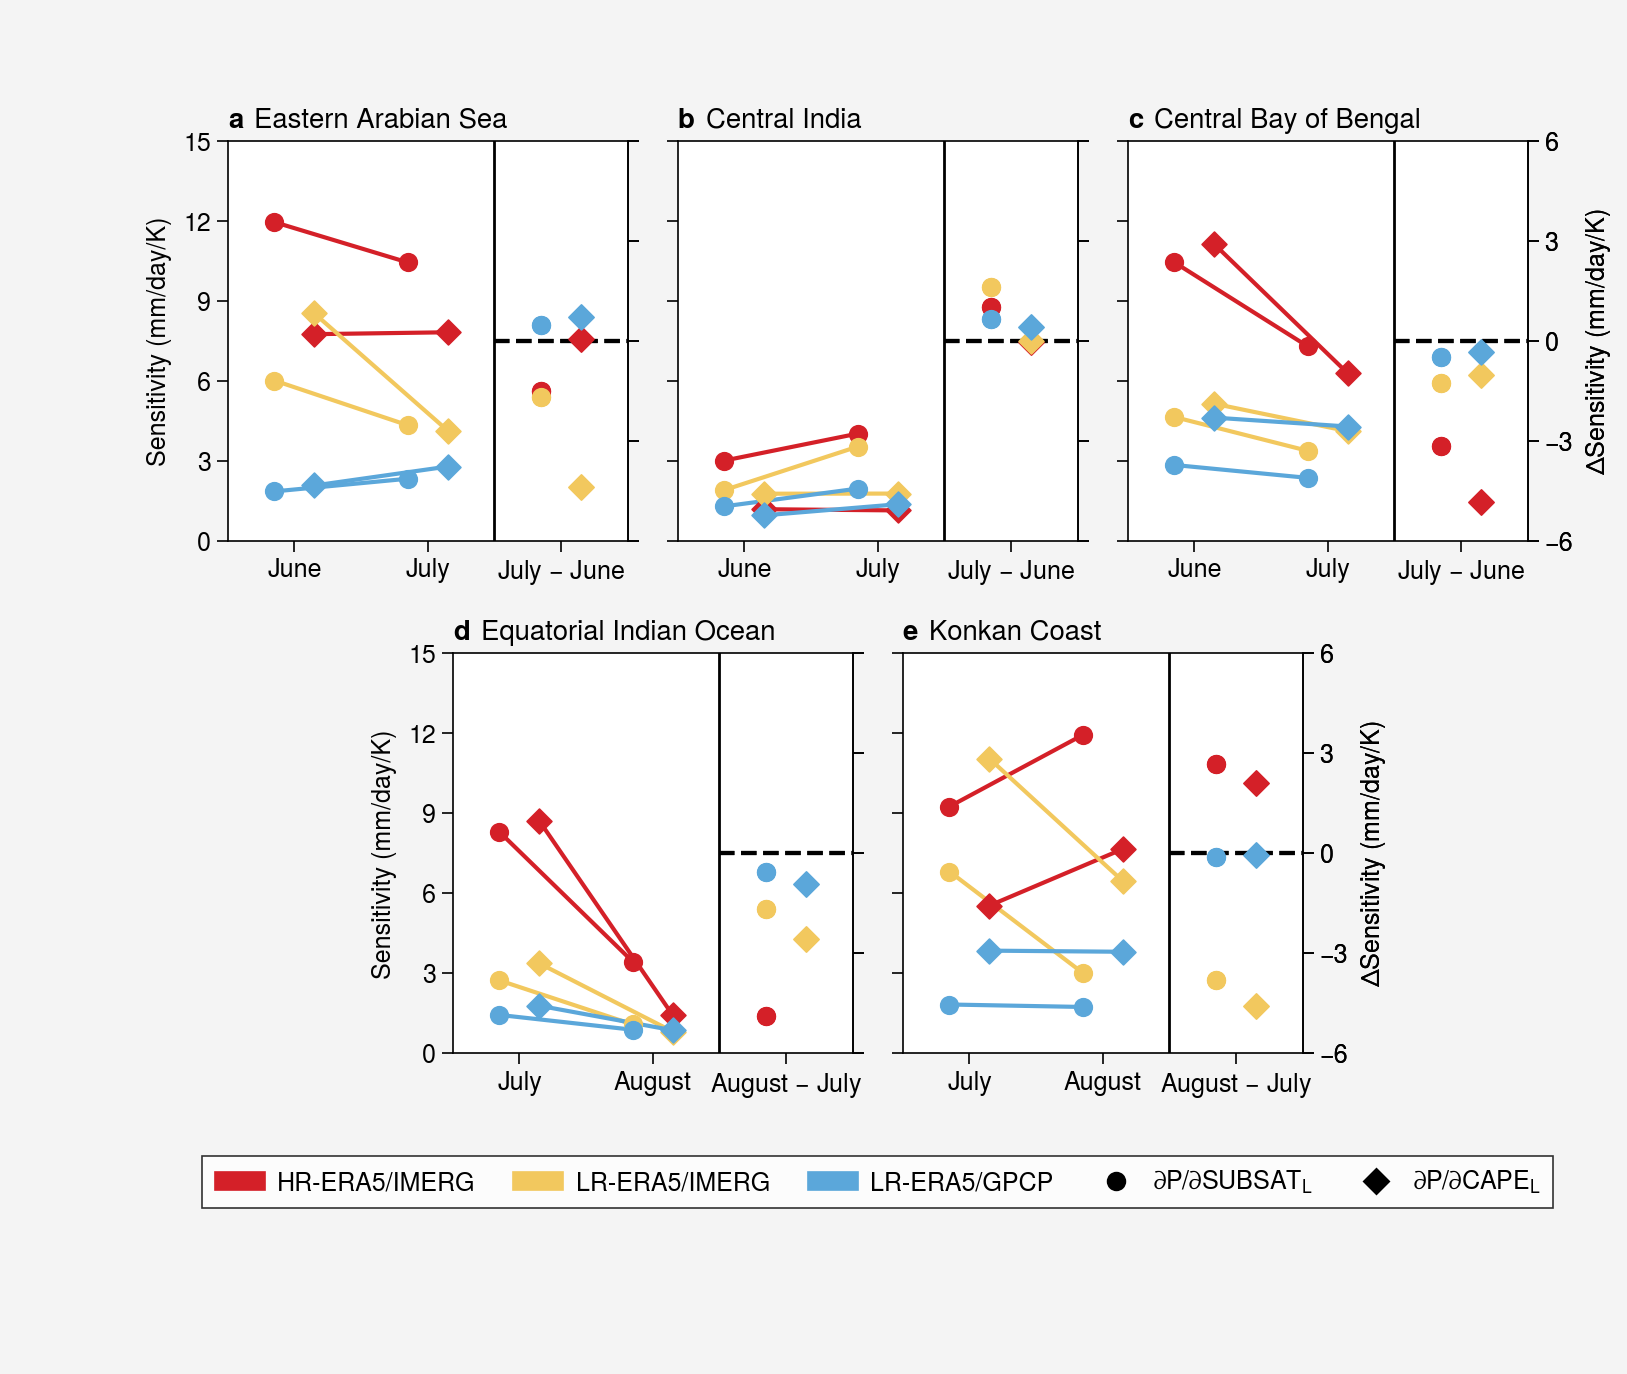

In [14]:
statsdict = [
    (hrimergstats,'HR-ERA5/IMERG'),
    (lrimergstats,'LR-ERA5/IMERG'),
    (lrgpcpstats,'LR-ERA5/GPCP')]
create_plot(statsdict,filename='fig_5.png')